In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from pymongo import MongoClient
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from talib import abstract
import math

from functools import partial

In [2]:
#Download Data from yahoo
### TEST Scnarios - TCS- Bull ,ACC- modrate up (Sidewase),YESBank- Back to Zero ,ITC(stock dosnt even Move)
stock='ACC'
startdate='2007-01-01'
enddate='2022-01-01'
exchange=['.NS','.BO']
dfo = yf.download(stock+exchange[0],start=startdate)

[*********************100%***********************]  1 of 1 completed


In [3]:
def pxline(to_plot):
    fig = px.line(to_plot)
    fig.show()

In [4]:
df=dfo.copy()
df['P_Daily_Change']=df['Close'].pct_change().apply(lambda x: round(x,2))
df.dropna(inplace=True)

In [64]:
##[pos]-->11 buy
##[pos]-->1 Continue
##[pos]-->0 Sell
def conditions(df):
    
    ########Buy In strength##########
    # df['In']=np.where(df['Close'].shift(1)>df['High'].shift(2).rolling(84).max(),1,0)
    # df['Out']=np.where(df['Close']<df['Low'].shift(1).rolling(21).min(),0,1)
    df['In']=np.where((df['Close']>df['High'].shift(1).rolling(84).max()) & (df['Close']>df['High'].shift(1).rolling(126).max()),1,0)
    df['Out']=np.where(df['Close']<df['Low'].shift(1).rolling(21).max(),0,1)
    
    
    
    
    
    #######Buy In Weekness###########
    # df['In']=np.where((df['Low'].rolling(21).min()>df['Low'].shift(1).rolling(189).min())&(df['Low'].shift(1).rolling(21).min()==df['Low'].shift(2).rolling(189).min()) ,1,0)
    # df['Out']=np.where(df['Close']<df['Low'].shift(1).rolling(126).min(),0,1)
    
    

    
    for i in df.index:
        df.at[i,'pos']=str(df['In'][i])+str(df['Out'][i])
    df['pos']=df['pos'].astype(str).astype(int)
    return df

In [65]:
df=dfo.copy()
df['P_Daily_Change']=df['Close'].pct_change().apply(lambda x: round(x,2))
df.dropna(inplace=True)

In [66]:

df=conditions(df=df)

In [68]:
port=pd.DataFrame(df.index).assign(Cash=0)
port.set_index('Date',inplace=True)
port.iloc[0,0]=100000

In [9]:
# fig = make_subplots(specs=[[{"secondary_y": True}]])

# # Add traces
# fig.add_trace(
#     go.Scatter(x=df.index, y=df['Close'], name="Close"),
#     secondary_y=False,
# )

# fig.add_trace(
#     go.Scatter(x=df.index, y=df['pos'], name="pos"),
#     secondary_y=True,
# )

# fig.show()


In [69]:
assets=['YesBank']
for asset in assets:
    globals()[asset]=pd.DataFrame(df.index).assign(ACash=0,Trade_Count=0,PositionDays=0,BuyPrice=0,ABuyPrice=0,SellPrice=0,CurrentPrice=0,Quantity=0,DailyPNL=0,DailyPerChange=0.0)
    globals()[asset].set_index('Date',inplace=True)
    globals()[asset].iloc[0,0]=100000
  

In [70]:
pos=0
days_in_pos=0
for i in df.index:
    if i != df.index[0]:
        buy= (df['pos'][i]== 11) and (df['pos'].shift(1)[i]==1)
        sell= (df['pos'][i]== 0) and (df['pos'].shift(1)[i]==1)
        
        
        if buy: # Buy Triggred
            if pos==0:
                pos=1
                current_price=df['Close'][i]
                YesBank.at[i,'Trade_Count']=1

            else : # Neither Not in Trade at this moment
                days_in_pos+=1
                current_price=df['Close'][i]
                YesBank.at[i,'Trade_Count']=1
                YesBank.at[i,'PositionDays']=days_in_pos
                
                Today_Change=df['P_Daily_Change'][i]
                YesBank.at[i,'DailyPerChange']=Today_Change
                
        if sell: # Sell Triggred
            if pos==1:
                print('Sell Triggred')
                pos=0
                YesBank.at[i,'Trade_Count']=0
                days_in_pos=0
                
        if not buy or sell: ##No Buy or Sell Triggred but trade could be already in Place
            if pos==1:
                days_in_pos+=1
                current_price=df['Close'][i]
                YesBank.at[i,'Trade_Count']=1
                YesBank.at[i,'PositionDays']=days_in_pos
                
                Today_Change=df['P_Daily_Change'][i]
                YesBank.at[i,'DailyPerChange']=Today_Change
            if pos==0:
                pass
                
            
            
      
            
     
            

Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred
Sell Triggred


In [71]:
YesBank['CReturns']=(((1+YesBank['DailyPerChange']).cumprod()-1)*100).apply(lambda x:round(x,2))

In [72]:
YesBank[-1:]

ACash  Trade_Count  PositionDays  BuyPrice  ABuyPrice  SellPrice  \
Date                                                                           
2022-02-21      0            0             0         0          0          0   

            CurrentPrice  Quantity  DailyPNL  DailyPerChange  CReturns  
Date                                                                    
2022-02-21             0         0         0             0.0     63.72

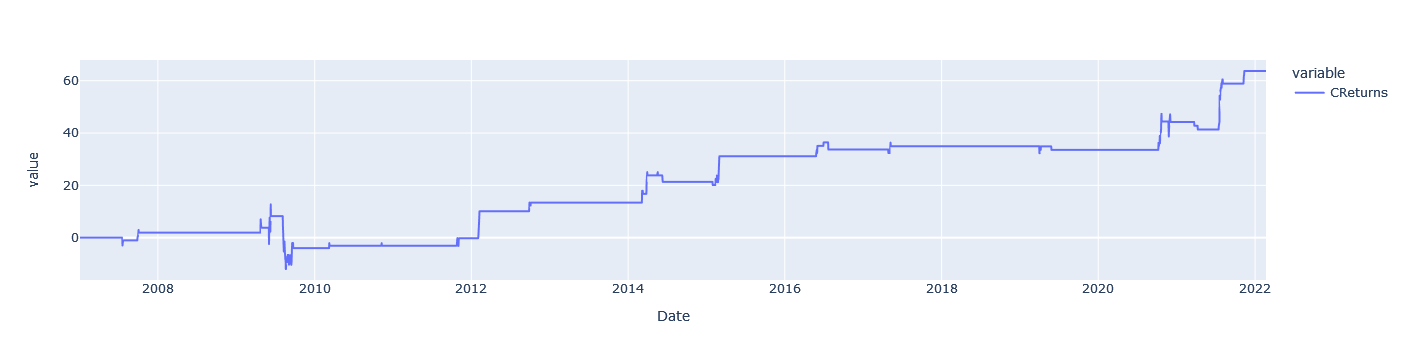

In [73]:
pxline(YesBank.CReturns)

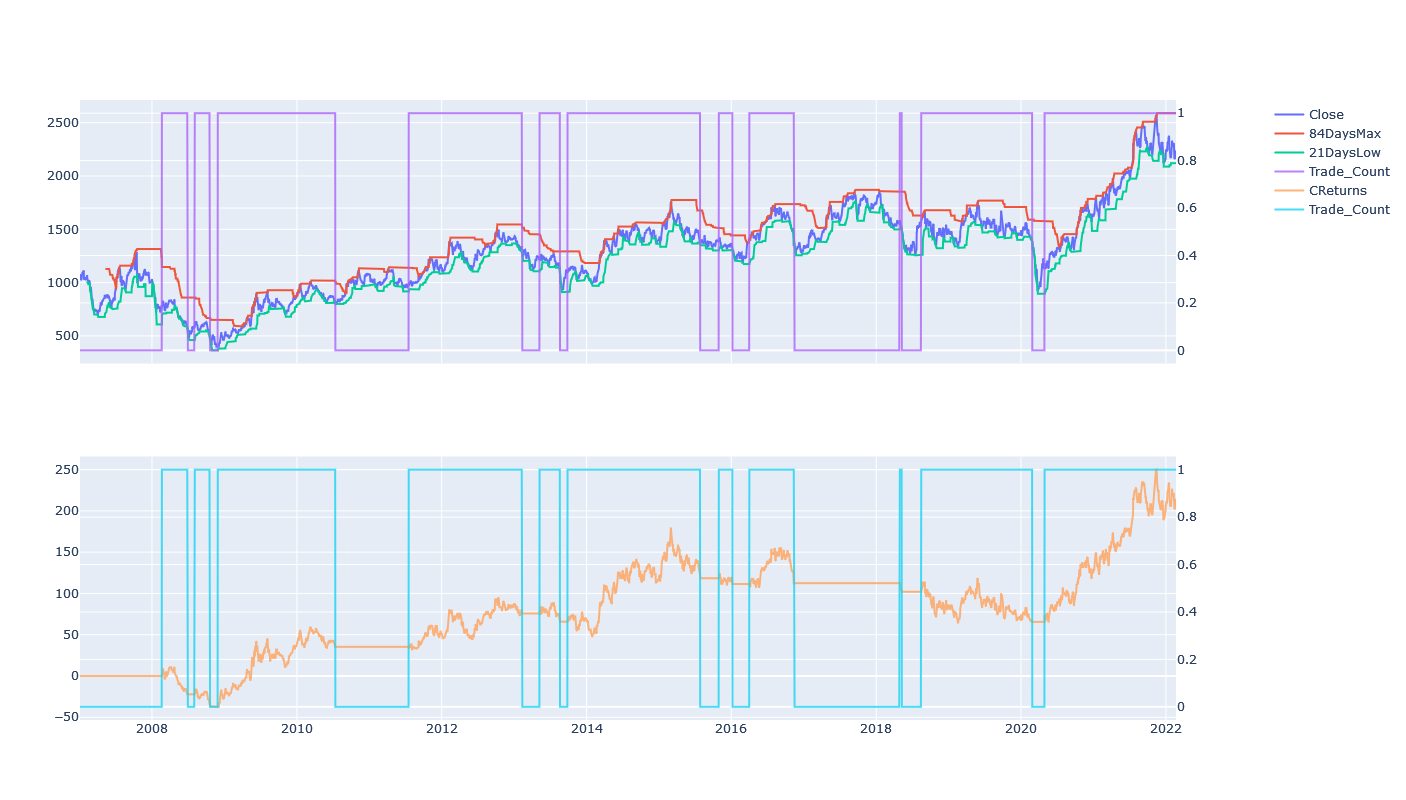

In [15]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,specs=[[{"secondary_y": True}],
                                          [{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close'),row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.index,y=df['High'].shift(2).rolling(84).max(),mode='lines',name='84DaysMax'),row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.index,y=df['Low'].shift(1).rolling(21).min(),mode='lines',name='21DaysLow'),row=1, col=1, secondary_y=False)

fig.add_trace(go.Scatter(x=YesBank.index,y=YesBank['Trade_Count'],mode='lines',name='Trade_Count',opacity=0.8),row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=YesBank.index,y=YesBank['CReturns'],mode='lines',name='CReturns',opacity=0.8),row=2, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=YesBank.index,y=YesBank['Trade_Count'],mode='lines',name='Trade_Count',opacity=0.8),row=2, col=1, secondary_y=True)



fig.update_traces(dict(marker_line_width=0))
fig.update_layout(autosize=False,width=1200,height=800,paper_bgcolor="white",barmode='overlay',activeshape_opacity=0.5)
fig.show()


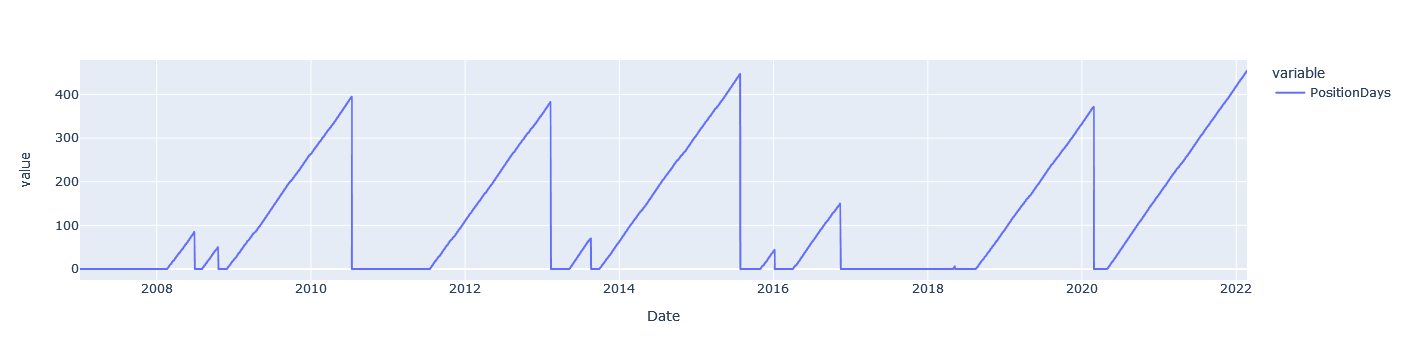

In [16]:
pxline(YesBank.PositionDays)

In [17]:
def cum_change(df,days):
    for day in days:
        df[f'{day}Change']=round(df.Close/df.Close.shift(day,fill_value=0)-1,2).replace(to_replace=np.inf,value=0)
    return df

In [18]:
# #This is how to calculate % change dinamically 
# round(df.Close/df.Close.shift(1,fill_value=0)-1,2).replace(to_replace=np.inf,value=0)


In [19]:
days=[126,252]
df=cum_change(df=df,days=days)

In [20]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2007-01-03  1080.000000  1104.400024  1067.000000  1073.599976   789.901489   
2007-01-04  1083.500000  1089.800049  1064.000000  1071.800049   788.577454   
2007-01-05  1080.000000  1080.000000  1045.099976  1054.699951   775.996033   
2007-01-08  1055.000000  1059.949951  1020.049988  1028.650024   756.829529   
2007-01-09  1035.000000  1042.800049  1012.150024  1025.500000   754.512146   
...                 ...          ...          ...          ...          ...   
2022-02-15  2156.500000  2240.000000  2156.500000  2234.300049  2234.300049   
2022-02-16  2250.000000  2266.250000  2215.399902  2239.399902  2239.399902   
2022-02-17  2240.399902  2267.550049  2215.750000  2226.850098  2226.850098   
2022-02-18  2208.750000  2220.000000  2172.000000  2181.149902  2181.149902   
2022-02-21  2178.699951  2205.250000  2151.000000  2184.899902  2184.899902   

            Volume  P_Daily_Change  In  Out  pos  126Change  252Change  
Date                                                                    
2007-01-03  429012           -0.02   0    1    1       0.00       0.00  
2007-01-04  448277           -0.00   0    1    1       0.00       0.00  
2007-01-05  319430           -0.02   0    1    1       0.00       0.00  
2007-01-08  311429           -0.02   0    1    1       0.00       0.00  
2007-01-09  507420           -0.00   0    1    1       0.00       0.00  
...            ...             ...  ..  ...  ...        ...        ...  
2022-02-15  259988            0.04   0    1    1      -0.03       0.27  
2022-02-16  218682            0.00   0    1    1      -0.02       0.27  
2022-02-17  218668           -0.01   0    1    1      -0.04       0.25  
2022-02-18  295149           -0.02   0    1    1      -0.07       0.24  
2022-02-21  291066            0.00   0    1    1      -0.05       0.22  

[3732 rows x 12 columns]

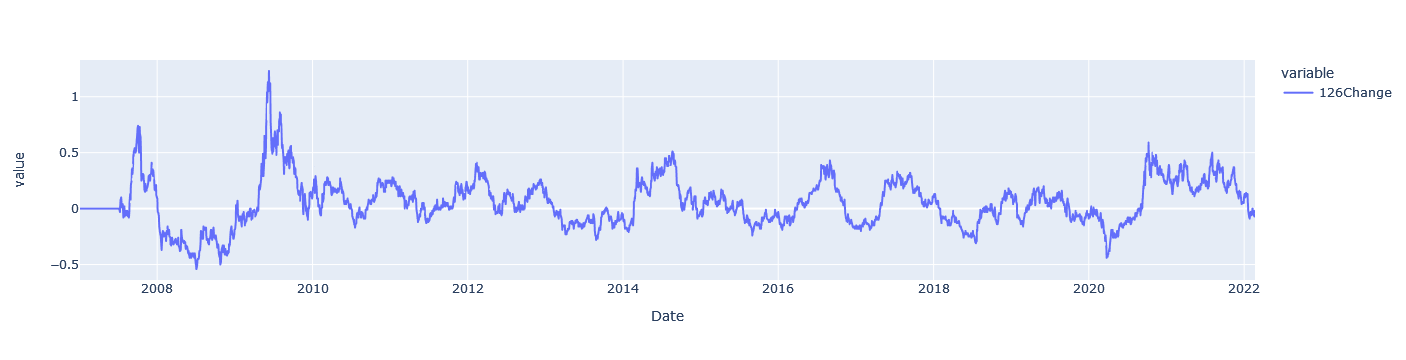

In [21]:
pxline(df['126Change'])

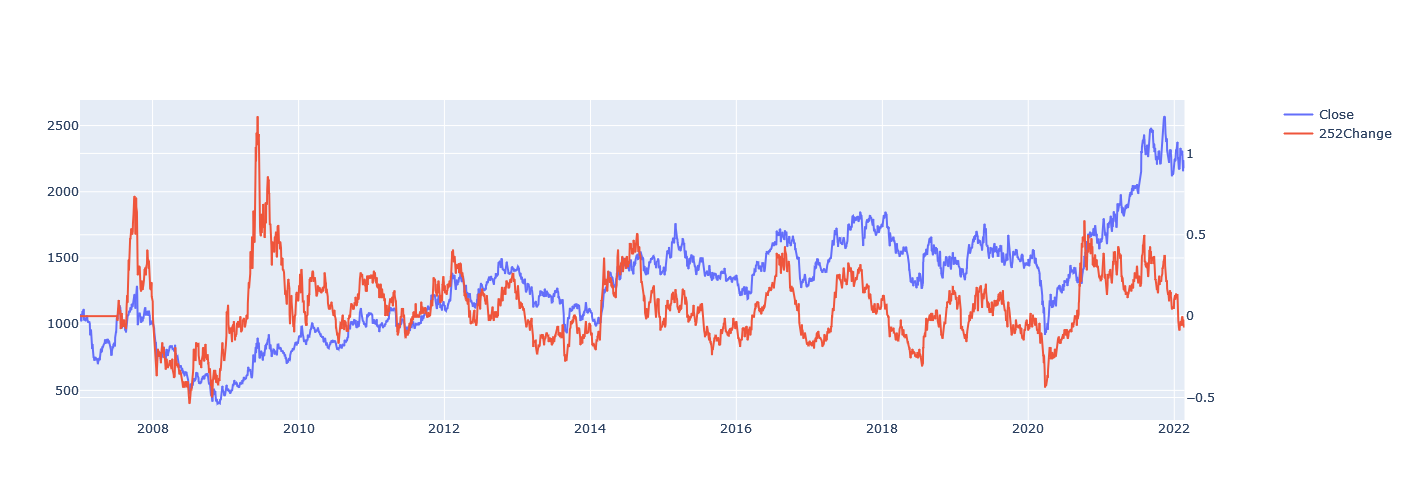

In [22]:
fig = make_subplots(rows=1, cols=1,shared_xaxes=True,specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close'),row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.index,y=df['126Change'],mode='lines',name='252Change'),row=1, col=1, secondary_y=True)

fig.update_traces(dict(marker_line_width=0))
fig.update_layout(autosize=False,width=1200,height=500,paper_bgcolor="white",barmode='overlay',activeshape_opacity=0.5)
fig.show()

In [23]:
def fractal(df,day):
    ll=0
    hh=0
    poscounter=0
    negcounter=0
    df['LLFormedDay']=0
    df['PostiveChange']=0.0
    df['HHFormedDay']=0
    df['NegtiveChange']=0.0
    # df['PostiveChangeAvg']=0.0
    # df['NegtiveChangeAvg']=0.0
    for i in df.index:
        loopcount=0
        if i != df.index[0]:
            if ll==0:
                if df['Close'][i]>df['Close'].shift(day)[i]:
                    hh=0 
                    df.at[i,'NegtiveChange']=0
                    negcounter=0
                    ll=df['Close'].shift(1)[i]
                    lldate=i
                    df.at[i,'PostiveChange']=(df['Close'][i]/ll)-1


            if hh==0:
                if df['Close'][i]<df['Close'].shift(day)[i]:
                    ll=0
                    df.at[i,'PostiveChange']=0
                    poscounter=0
                    hh=df['Close'].shift(1)[i]
                    hhdate=i
                    df.at[i,'NegtiveChange']=(df['Close'][i]/hh)-1



            if ll!=0:
                if df['Close'][i]>ll:
                    negcounter=0
                    poscounter=poscounter+1             
                    
                    df.at[i,'LLFormedDay']=poscounter
                    poschange=(df['Close'][i]/ll)-1
                    df.at[i,'PostiveChange']=poschange
                    
                    # if poscounter!=0:
                    #     posavg=poschange/poscounter
                    #     df.at[i,'PostiveChangeAvg']=posavg
                        

            if hh!=0:
                if df['Close'][i]<hh:
                    poscounter=0
                    negcounter=negcounter+1

                    df.at[i,'HHFormedDay']=negcounter
                    negchange=(df['Close'][i]/hh)-1
                    df.at[i,'NegtiveChange']=negchange
                    # if negcounter!=0:
                    #     negavg=negchange/negcounter
                    #     df.at[i,'NegtiveChangeAvg']=negavg
                        
                    

        loopcount+=1
    df=df.apply(lambda x:round(x,2))
    return df
                

In [31]:
df=dfo.copy()
df['P_Daily_Change']=df['Close'].pct_change().apply(lambda x: round(x,2))
df.dropna(inplace=True)
df1=fractal(df=df,day=126)

In [32]:
df=dfo.copy()
df['P_Daily_Change']=df['Close'].pct_change().apply(lambda x: round(x,2))
df.dropna(inplace=True)
df=fractal(df=df,day=42)

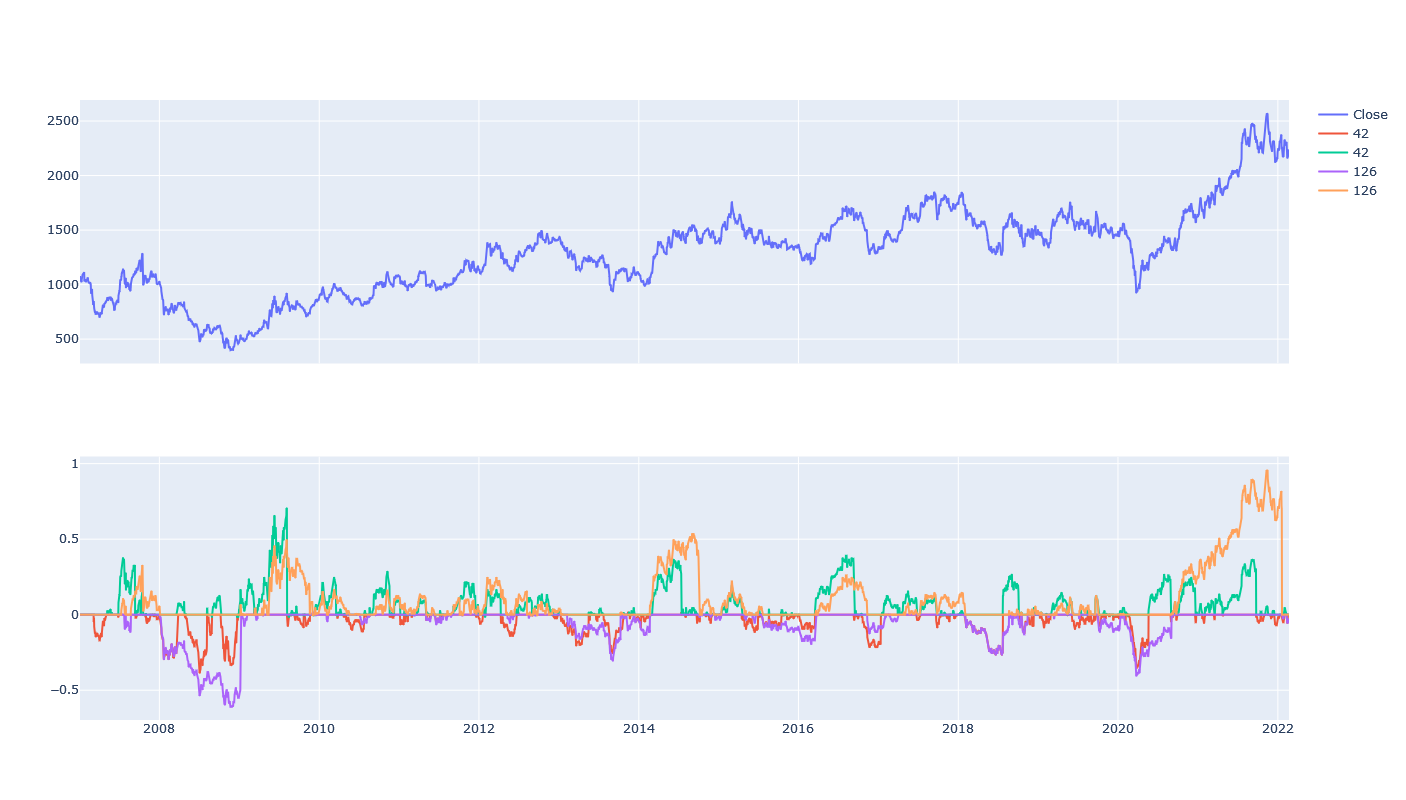

In [33]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True,)#specs=[[{"secondary_y": True}]]

fig.add_trace(go.Scatter(x=df.index,y=df['Close'],mode='lines',name='Close'),row=1, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['NegtiveChange'],mode='lines',name='42'),row=2, col=1)
fig.add_trace(go.Scatter(x=df.index,y=df['PostiveChange'],mode='lines',name='42'),row=2, col=1)
fig.add_trace(go.Scatter(x=df1.index,y=df1['NegtiveChange'],mode='lines',name='126'),row=2, col=1)
fig.add_trace(go.Scatter(x=df1.index,y=df1['PostiveChange'],mode='lines',name='126'),row=2, col=1)



fig.update_traces(dict(marker_line_width=0))
fig.update_layout(autosize=False,width=1200,height=800,paper_bgcolor="white",barmode='overlay',activeshape_opacity=0.5)
fig.show()

In [34]:
def LastClose(df,days):
    for day in days:
        df[f'{day}Close']=df['Close'].shift(day)
        df[f'{day}High']=df['High'].shift(day)
        df[f'{day}Low']=df['Low'].shift(day)
    df.dropna(inplace=True)
    return df


In [35]:
df=dfo.copy()
df['P_Daily_Change']=df['Close'].pct_change().apply(lambda x: round(x,2))
df.dropna(inplace=True)

days=[10,21,42,84,126,189,252]
df=LastClose(df,days)

In [36]:
df.head()

Open         High         Low       Close   Adj Close  \
Date                                                                       
2008-01-08  1001.000000  1007.599976  977.650024  985.299988  747.471680   
2008-01-09   971.250000   992.000000  960.000000  970.000000  735.864563   
2008-01-10   970.099976   979.700012  935.000000  938.849976  712.233582   
2008-01-11   950.000000   950.000000  888.000000  898.700012  681.774902   
2008-01-14   901.000000   901.500000  864.299988  876.549988  664.971252   

             Volume  P_Daily_Change      10Close       10High        10Low  \
Date                                                                         
2008-01-08  1179008           -0.02  1001.750000  1075.699951   996.400024   
2008-01-09   922322           -0.02  1005.500000  1023.799988  1001.150024   
2008-01-10   632935           -0.03  1003.799988  1019.950012   998.000000   
2008-01-11   817249           -0.04  1010.549988  1017.000000   994.000000   
2008-01-14   645794           -0.02  1024.800049  1033.000000  1012.000000   

            ...        84Low     126Close      126High  126Low    189Close  \
Date        ...                                                              
2008-01-08  ...  1060.000000  1047.900024  1055.000000  1011.0  741.650024   
2008-01-09  ...  1083.599976  1035.750000  1051.900024  1029.0  747.299988   
2008-01-10  ...  1075.000000  1071.500000  1084.000000  1021.0  732.450012   
2008-01-11  ...  1090.000000  1075.400024  1086.000000  1067.0  726.349976   
2008-01-14  ...  1099.000000  1103.650024  1122.699951  1080.0  748.299988   

               189High  189Low     252Close      252High       252Low  
Date                                                                   
2008-01-08  744.299988  726.50  1073.599976  1104.400024  1067.000000  
2008-01-09  753.500000  733.50  1071.800049  1089.800049  1064.000000  
2008-01-10  747.099976  711.50  1054.699951  1080.000000  1045.099976  
2008-01-11  733.900024  720.25  1028.650024  1059.949951  1020.049988  
2008-01-14  750.000000  726.00  1025.500000  1042.800049  1012.150024  

[5 rows x 28 columns]

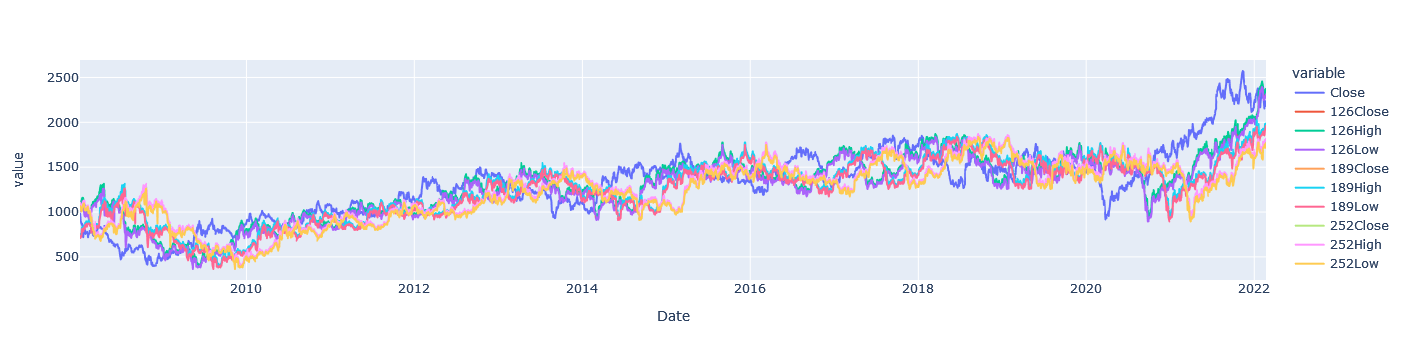

In [37]:
pxline(df[['Close','126Close','126High','126Low','189Close','189High','189Low','252Close','252High','252Low']])

In [ ]:
def LastHigh(df,days):
    for day in days:
        df[f'{day}High']=df['High'].shift(day)
    df.dropna(inplace=True)
    return df